In [22]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('wowah_data.csv')

In [3]:
df.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


In [5]:
## 전처리

In [6]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [7]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [8]:
df = df.rename(columns={'time':'datetime'})

In [9]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [10]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

In [11]:
#session playtime
session_end_re = pd.read_csv('session_end.csv')

In [12]:
#dau
dau = pd.DataFrame(df.groupby('date').char.nunique()).reset_index()

In [13]:
#guild

In [14]:
#총 길드 개수
df.guild.nunique()

420

In [16]:
noguild_user = df[df.guild==-1].reset_index()
noguild_daily = noguild_user.groupby('date').char.nunique().reset_index()

In [17]:
noguild_daily = pd.merge(dau, noguild_daily, how='left', on='date')

In [18]:
noguild_daily = noguild_daily.rename(columns={'char_x':'dau', 'char_y':'noguild'})

In [19]:
noguild_daily['noguild_perc'] = noguild_daily['noguild'] / noguild_daily['dau']

In [20]:
noguild_daily['noguild_perc'] = [round(x, 2) for x in noguild_daily['noguild_perc']]

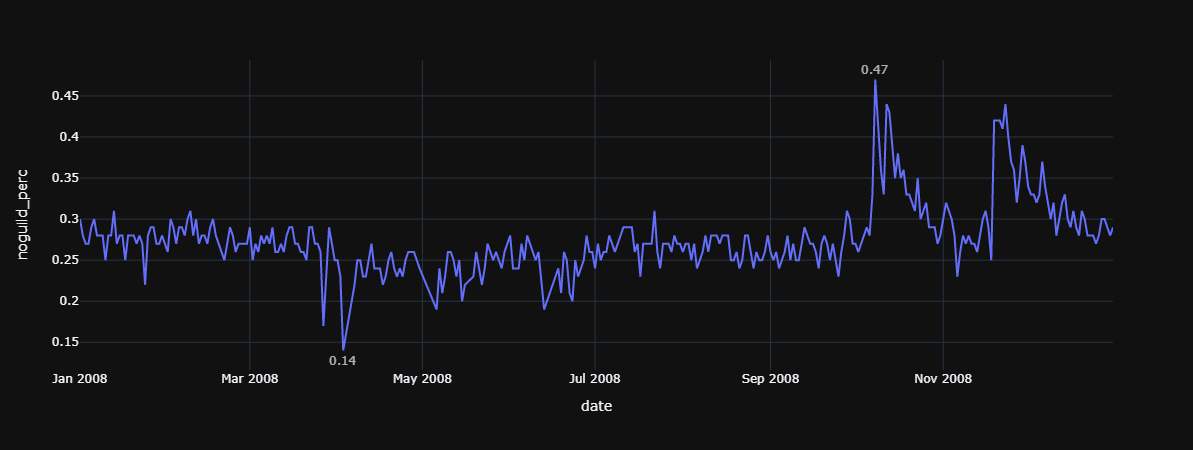

In [135]:
#dau 중 길드가 없는 유저의 비율
fig = px.line(noguild_daily, x='date', y='noguild_perc', template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=noguild_daily.date[noguild_daily.max(axis = 1).idxmax()],
                   y=noguild_daily.max().noguild_perc,
                   text=str(noguild_daily.max().noguild_perc),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=noguild_daily.date[noguild_daily.min(axis = 1).idxmin()],
                   y=noguild_daily.min().noguild_perc,
                   text=str(noguild_daily.min().noguild_perc),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/noguild_percentage.png")

In [ ]:
# 길드 사이즈 구하기
# 가능한 최대 길드원은 1000명.
# 해당 데이터로 길드별 가입자 수를 정확히 알긴 어려우나, 월별 접속자수롤 구한 뒤 그 최대값으로 추정하고자 함.

In [24]:
guild_size = df.groupby(by=['guild']).char.nunique().reset_index()

In [25]:
guild_size_month = df.groupby(by=['guild', 'year', 'month']).char.nunique().reset_index()

In [26]:
guild_size = guild_size_month.groupby('guild').char.max().reset_index()

In [27]:
guild_size_re = guild_size[guild_size.guild!=-1]

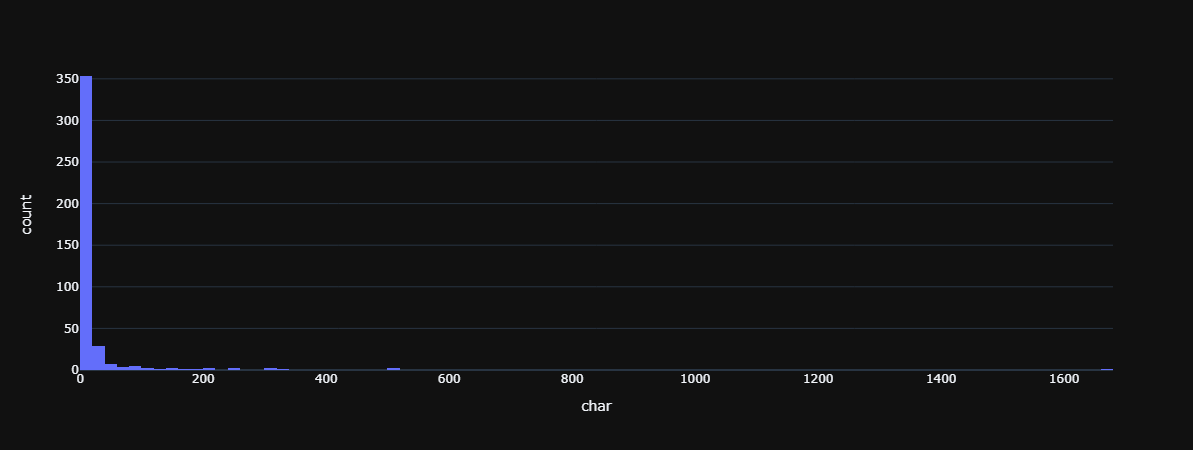

In [136]:
#대부분 소규모 길드이며 가장 규모가 큰 길드가 1750여명 정도임.
fig = px.histogram(guild_size_re, x="char", nbins=100, width=800, height=450, template='plotly_dark')
fig.show()
fig.write_image("img/guild_size_histogram.png")

In [29]:
guild_size_re['char'].describe()

count     419.000000
mean       23.978520
std        98.199787
min         1.000000
25%         2.000000
50%         6.000000
75%        11.000000
max      1676.000000
Name: char, dtype: float64

In [30]:
guild_size_re['char'].median()

6.0

In [31]:
guild_size_re.groupby('char').count().reset_index().sort_values(by='guild', ascending=False)[:10]

,char,guild
0,1,74
2,3,38
1,2,38
5,6,30
3,4,27
6,7,26
4,5,25
8,9,21
7,8,16
9,10,13


In [32]:
guild_size = guild_size.rename(columns={'char':'n_users'})

In [33]:
#규모가 가장 큰 길드 10곳
top_guilds = guild_size_re.sort_values(by='char', ascending=False)[:10]

In [34]:
len(guild_size_re[guild_size_re.char>100])

20

In [35]:
top_guild_users = df[df.guild.isin(list(top_guilds.guild))].reset_index()

In [36]:
top_guild_size = top_guild_users.groupby(by=['guild', 'date']).char.nunique().reset_index()

In [37]:
top_guild_size.guild = top_guild_size.guild.astype('str')

In [38]:
top_guild_size.guild = 'g_' + top_guild_size.guild 

<AxesSubplot:xlabel='date', ylabel='char'>

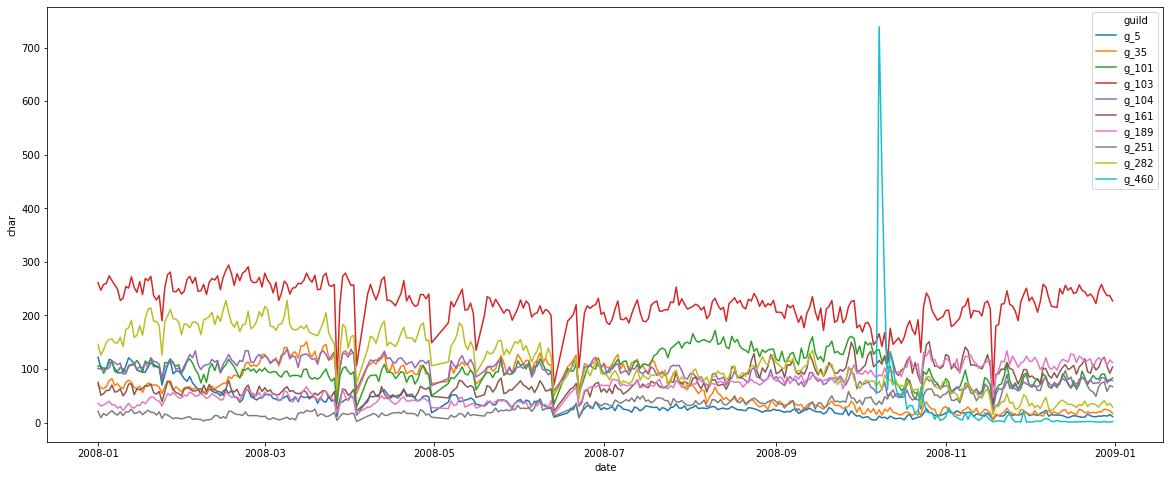

In [39]:
#대규모 길드별 데일리 접속자 수(중복제거)
plt.figure(figsize = (20,8))
sns.lineplot(x='date', y='char', data=top_guild_size, hue='guild')

* 460번 길드는 2008년 10월경 신설된 후 접속자 수가 폭발적으로 늘었으나 이후 급감 : 아마 신규 확장팩 런칭 영향으로 보임
* 대부분의 대규모 갤드는 일별 접속자 수가 꾸준히 유지되는 모습을 보이나, 204번길드처럼 급감하는 곳도 있음. 

In [40]:
# 길드 가입 유무에 따른 리텐션

#유저별로 첫번째 접속한 월(코호트)
first_logintime = df.groupby(by=['char'])['datetime'].min().reset_index()
first_logintime = first_logintime.rename(columns={'datetime':'first_login_t'})

In [41]:
first_logintime['first_login_month'] = first_logintime.first_login_t.dt.strftime('%Y-%m')

In [42]:
first_logintime['first_login_date'] = first_logintime.first_login_t.dt.date

In [43]:
first_logintime_re = first_logintime[['char', 'first_login_month']]

In [44]:
df_merged = pd.merge(df, first_logintime[['char', 'first_login_date', 'first_login_month']], how='left', on='char')

In [45]:
df_merged_re = pd.merge(df_merged, guild_size, on='guild', how='left')

In [46]:
#길드에 가입한 유저와 그렇지 않은 유저 구분
user_guild = df.groupby('char').guild.max().reset_index()

In [47]:
user_guild['guild_join'] = [ 'N'  if x==-1 else 'Y' for x in user_guild.guild ]

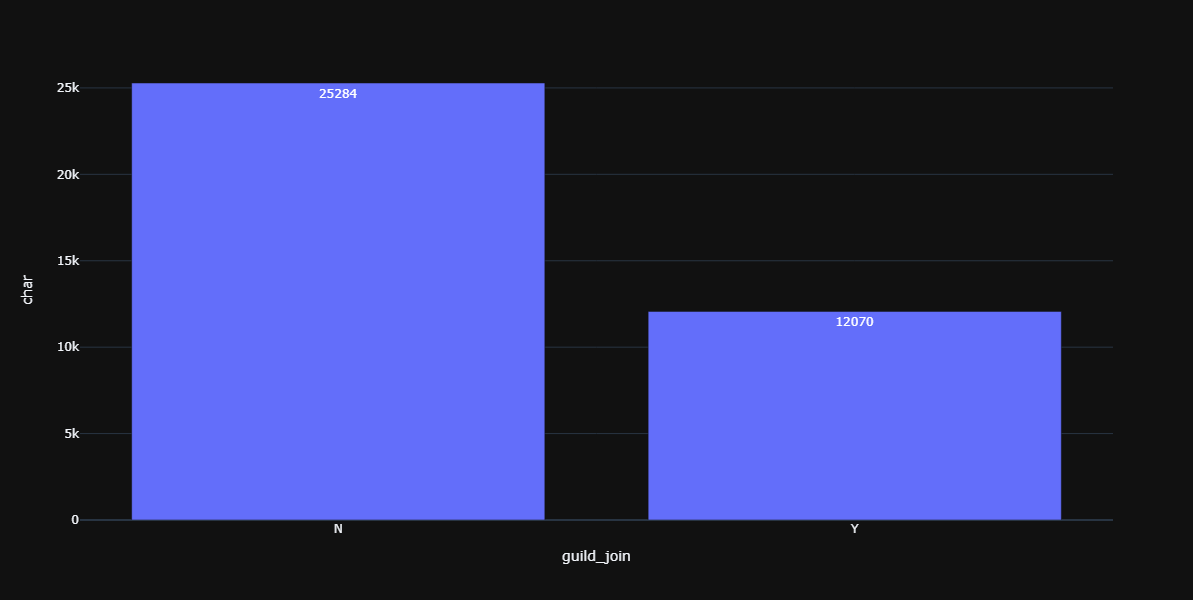

In [98]:
guild_count = user_guild.groupby('guild_join').char.count().reset_index()

fig = px.bar(guild_count, x='guild_join', y='char', text='char', template='plotly_dark', width=800, height=600)
fig.show()
fig.write_image("img/guild_or_not.png")

In [49]:
df_merged_re = pd.merge(df_merged_re, user_guild[['char', 'guild_join']], on='char', how='left')

In [50]:
df_merged_re['day_played'] = df_merged_re['date'] - df_merged_re['first_login_date']

In [51]:
import math
df_merged_re['months_played'] = [math.floor(dt) for dt in (df_merged_re.day_played.dt.days / 30)]

In [105]:
df_with_guild = df_merged_re[df_merged_re.guild_join=='Y'].reset_index(drop=True)
df_solo = df_merged_re[df_merged_re.guild_join=='N'].reset_index(drop=True)

In [106]:
cohort_played_guild = pd.pivot_table(df_with_guild, index=['first_login_month'], columns =['months_played'], values='char', aggfunc=pd.Series.nunique)

retention_guild = []
for col in cohort_played_guild.columns:
    retention_i = cohort_played_guild[col].fillna(0).sum() / (cohort_played_guild[col].fillna(0).astype('bool').astype('int') * cohort_played_guild[0]).sum()
    retention_guild.append(retention_i)

cohort_played_noguild = pd.pivot_table(df_solo, index=['first_login_month'], columns =['months_played'], values='char', aggfunc=pd.Series.nunique)

retention_noguild = []
for col in cohort_played_noguild.columns:
    retention_i = cohort_played_noguild[col].fillna(0).sum() / (cohort_played_noguild[col].fillna(0).astype('bool').astype('int') * cohort_played_noguild[0]).sum()
    retention_noguild.append(retention_i)

In [107]:
retention_guild_m = pd.DataFrame({'months_played':list(cohort_played_guild.columns[1:]), 'with_guild':retention_guild[1:], 'no_guild': retention_noguild[1:]})

In [108]:
retention_guild_m = retention_guild_m.set_index('months_played').stack().reset_index()

In [109]:
retention_guild_m = retention_guild_m.rename(columns={'level_1':'guild', 0:'retention'})

In [121]:
retention_guild_m['retention'] = [round(x, 2) for x in retention_guild_m['retention']]

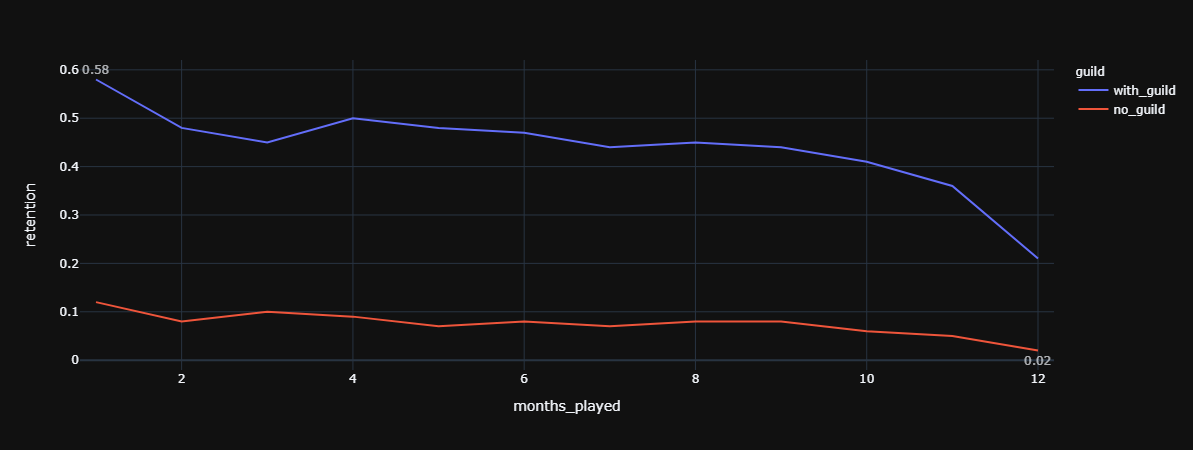

In [123]:
fig = px.line(retention_guild_m, x="months_played", y="retention", color="guild", template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild_m.months_played[retention_guild_m.retention.idxmax()],
                   y=retention_guild_m.max().retention,
                   text=str(retention_guild_m.max().retention),
                   yshift=10,
                   opacity=0.7)

fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild_m.months_played[retention_guild_m.retention.idxmin()],
                   y=retention_guild_m.min().retention,
                   text=str(retention_guild_m.min().retention),
                   yshift=-10,
                   opacity=0.7)

fig.show()
fig.write_image("img/retention_guild_join.png")

In [66]:
retention_guild.groupby('guild').retention.mean()

guild
no_guild      0.075447
with_guild    0.440472
Name: retention, dtype: float64

In [125]:
#일별 리텐션

cohort_played_guild = pd.pivot_table(df_with_guild, index=['first_login_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)

retention_guild = []
for col in cohort_played_guild.columns:
    retention_i = cohort_played_guild[col].fillna(0).sum() / (cohort_played_guild[col].fillna(0).astype('bool').astype('int') * cohort_played_guild['0 days']).sum()
    retention_guild.append(retention_i)

cohort_played_noguild = pd.pivot_table(df_solo, index=['first_login_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)

retention_noguild = []
for col in cohort_played_noguild.columns:
    retention_i = cohort_played_noguild[col].fillna(0).sum() / (cohort_played_noguild[col].fillna(0).astype('bool').astype('int') * cohort_played_noguild['0 days']).sum()
    retention_noguild.append(retention_i)
    

In [126]:
retention_guild = pd.DataFrame({'days_played':list(cohort_played_guild.columns[1:]), 'with_guild':retention_guild[1:], 'no_guild': retention_noguild[1:]})
retention_guild = retention_guild.set_index('days_played').stack().reset_index()
retention_guild = retention_guild.rename(columns={'level_1':'guild', 0:'retention'})

In [127]:
retention_guild['retention'] = [round(x, 2) for x in retention_guild['retention']]

In [128]:
retention_guild['days_played'] = [str(dt.days) + ' days' for dt in retention_guild['days_played'] ]

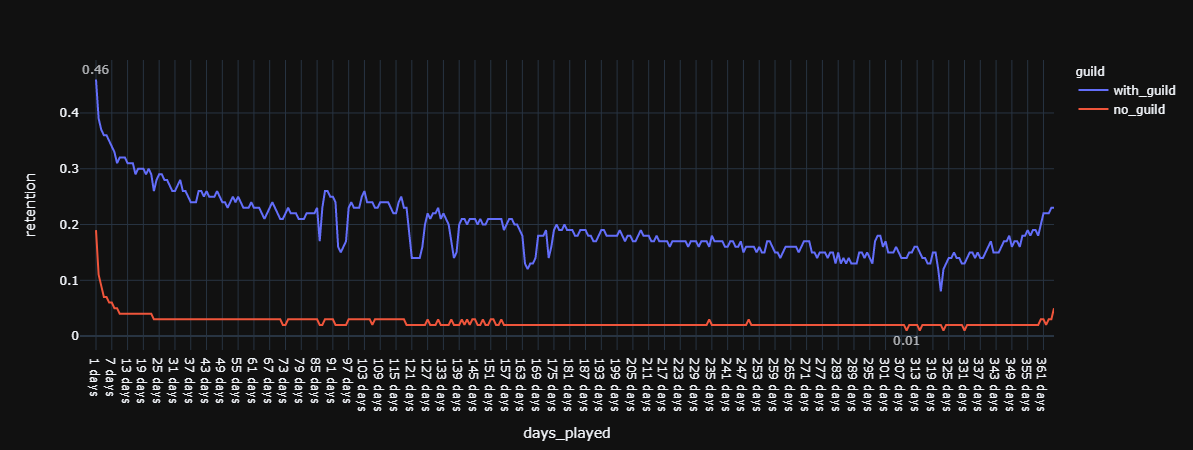

In [129]:
fig = px.line(retention_guild, x="days_played", y="retention", color="guild", template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild.days_played[retention_guild.retention.idxmax()],
                   y=retention_guild.max().retention,
                   text=str(retention_guild.max().retention),
                   yshift=10,
                   opacity=0.7)

fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild.days_played[retention_guild.retention.idxmin()],
                   y=retention_guild.min().retention,
                   text=str(retention_guild.min().retention),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/retention_daily_guild.png")

In [ ]:
#길드 규모와 리텐션의 관계

In [74]:
df_guild_join = df_merged_re[df_merged_re.guild_join=='Y'].reset_index(drop=True)

In [75]:
df_guild_join['guild_size'] = [ 'big'  if (x>11 and x>1) else 'small' for x in df_guild_join.n_users ] #75%인 11명을 기준으로 구분

In [76]:
user_guild = pd.merge(user_guild, guild_size,on='guild', how='left')

In [77]:
df_guild_join = pd.merge(df_guild_join, user_guild[['char', 'n_users']], on='char', how='left')

In [130]:
#일별 리텐션
guild_big = df_guild_join[df_guild_join.guild_size=='big'].reset_index(drop=True)
guild_small = df_guild_join[df_guild_join.guild_size=='small'].reset_index(drop=True)

cohort_guild_big = pd.pivot_table(guild_big, index=['first_login_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)
cohort_guild_small = pd.pivot_table(guild_small, index=['first_login_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)


retention_big = []
for col in cohort_guild_big.columns:
    retention_i = cohort_guild_big[col].fillna(0).sum() / (cohort_guild_big[col].fillna(0).astype('bool').astype('int') * cohort_guild_big['0 days']).sum()
    retention_big.append(retention_i)

    
retention_small = []
for col in cohort_guild_small.columns:
    retention_i = cohort_guild_small[col].fillna(0).sum() / (cohort_guild_small[col].fillna(0).astype('bool').astype('int') * cohort_guild_small['0 days']).sum()
    retention_small.append(retention_i)


In [131]:
retention_guild_size = pd.DataFrame({'days_played':list(cohort_guild_big.columns[1:]), 'big_guild':retention_big[1:], 'small_guild': retention_small[1:]})
retention_guild_size = retention_guild_size.set_index('days_played').stack().reset_index()
retention_guild_size = retention_guild_size.rename(columns={'level_1':'guild_size', 0:'retention'})

In [132]:
retention_guild_size['retention'] = [round(x, 2) for x in retention_guild_size['retention']]

In [133]:
retention_guild_size['days_played'] = [str(dt.days) + ' days' for dt in retention_guild_size['days_played'] ]

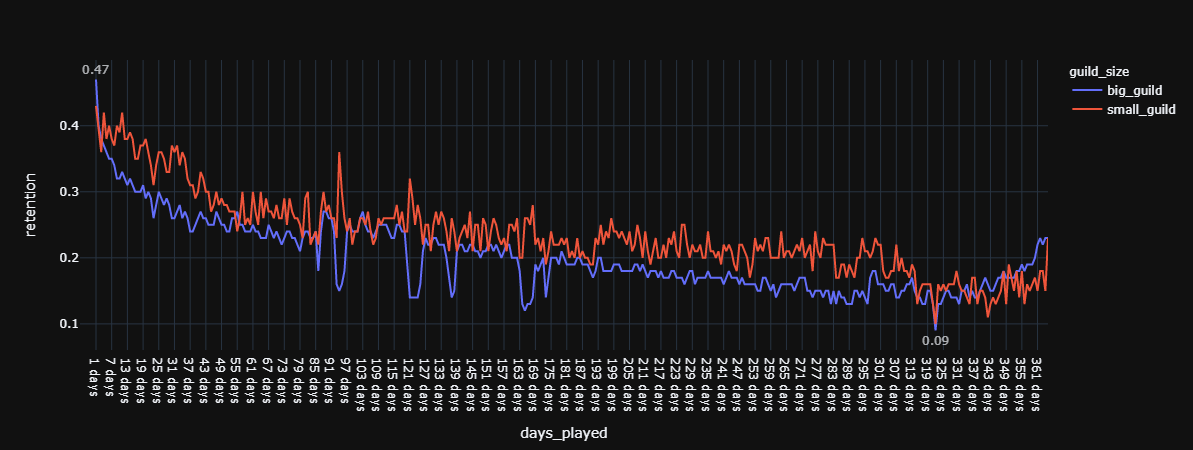

In [134]:
fig = px.line(retention_guild_size, x="days_played", y="retention", color="guild_size", template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild_size.days_played[retention_guild_size.retention.idxmax()],
                   y=retention_guild_size.max().retention,
                   text=str(retention_guild_size.max().retention),
                   yshift=10,
                   opacity=0.7)

fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=retention_guild_size.days_played[retention_guild_size.retention.idxmin()],
                   y=retention_guild_size.min().retention,
                   text=str(retention_guild_size.min().retention),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/retention_guild_size.png")

* 길드 규모가 큰 경우보다 작은 경우 리텐션이 더 높음.
* 길드 규모가 작으면 보다 응집력이 좋기 때문에 함께 모이는 시간과 목표를 정하기 쉽고, 게임에 꾸준히 접속할 유인이 늘어남.

In [321]:
# 길드 규모와 플레이 시간의 관계

In [187]:
guild_playtime = session_end_re.groupby('guild').agg({'playtime_hours':'sum', 'char':'nunique'}).reset_index()

In [188]:
guild_playtime['average_playtime'] = guild_playtime['playtime_hours'] / guild_playtime['char']

In [189]:
guild_playtime_re = guild_playtime[['guild', 'average_playtime']]

In [182]:
guild_size_playtime = pd.merge(guild_playtime_re, guild_size, how='left', on='guild')

In [183]:
guild_size

,guild,n_users
0,-1,8856
1,1,38
2,2,1
3,3,20
4,4,50
...,...,...
415,504,2
416,505,1
417,506,1
418,507,6


In [185]:
guild_size_playtime['n_users'].fillna(0, inplace=True)

In [142]:
guild_size_playtime_re = guild_size_playtime[guild_size_playtime.guild != -1] #길드가 없는 경우 제외
guild_size_playtime_re = guild_size_playtime_re[guild_size_playtime_re.n_users != 1] #길드원이 1명인 경우는 제외

<AxesSubplot:xlabel='n_users', ylabel='average_playtime'>

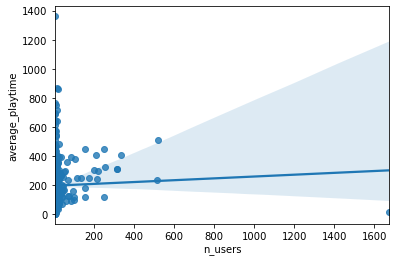

In [143]:
# 길드 사이즈와 플레이 시간의 상관관계
sns.regplot(x='n_users_y', y='average_playtime', data=guild_size_playtime_re)

In [144]:
#이상치 제거하기
iqr = guild_size_playtime_re['n_users'].quantile(0.75) - guild_size_playtime_re['n_users'].quantile(0.25)
outlier = (guild_size_playtime_re['n_users'] < guild_size_playtime_re['n_users'].quantile(0.25) - iqr * 1.5) | (guild_size_playtime_re['n_users'] > guild_size_playtime_re['n_users'].quantile(0.75) + iqr * 1.5)

In [145]:
guild_size_playtime_re['outlier'] = outlier

In [146]:
guild_size_playtime_re2 = guild_size_playtime_re[guild_size_playtime_re.outlier==False]

<AxesSubplot:xlabel='n_users', ylabel='average_playtime'>

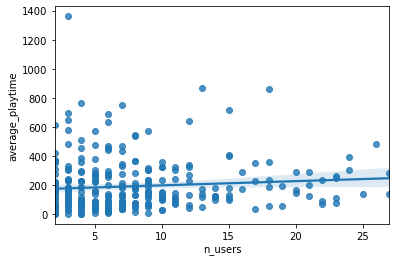

In [147]:
sns.regplot(x='n_users', y='average_playtime', data=guild_size_playtime_re2)

* 길드 규모가 늘어나면 플레이 시간이 증가 >> 길드에 가입안 한 유저들 가입하도록 독려할 필요가 있음.
* 길드를 서로 홍보할 수 있는 장을 마련
* 길드 규모를 늘리면 혜택을 추가 제공

* 어둠땅부턴 종족이나 직업 퀘스트/추방자의 해안으로 10레벨까지 / 격전의 아제로스 지역에서 50레벨까지 / 어둠땅 지역에서 60레벨까지

In [46]:
# 길드 규모와 zone type의 관계

In [148]:
zones = pd.read_csv('zones.csv')
locations = pd.read_csv('locations.csv')

In [149]:
zones_type = zones[['Zone_Name', 'Type']].rename(columns={'Zone_Name':'zone'})

In [150]:
df_zone_type = pd.merge(df, zones_type, how='left', on='zone')

In [151]:
df_zone_type.groupby('Type').char.count().sort_values(ascending=False)

Type
Zone            6513372
Dungeon         2308251
City             957109
Battleground     936464
Arena            110201
Sea                 978
Event               165
Transit              51
Name: char, dtype: int64

In [152]:
guild_zone = df_zone_type.groupby(by=['guild', 'Type']).char.count().sort_values(ascending=False)

In [153]:
guild_zone = pd.pivot_table(df_zone_type, values='char', index=['guild'], columns=['Type'], aggfunc='count').fillna(0)

In [154]:
guild_zone['total'] = guild_zone.sum(axis=1)

In [155]:
for col in guild_zone.columns:
    guild_zone[col+'_p'] = guild_zone[col] / guild_zone['total']

In [156]:
guild_zone_re = guild_zone[['Arena_p', 'Battleground_p', 'City_p', 'Dungeon_p', 'Event_p', 'Sea_p', 'Transit_p', 'Zone_p']]

In [157]:
guild_zone_re = guild_zone_re.reset_index()

In [158]:
guild_zone_re = pd.merge(guild_zone_re, guild_size_playtime, on='guild')

In [159]:
#이상치 제거하기
iqr = guild_zone_re['n_users'].quantile(0.75) - guild_zone_re['n_users'].quantile(0.25)
outlier = (guild_zone_re['n_users'] < guild_zone_re['n_users'].quantile(0.25) - iqr * 1.5) | (guild_zone_re['n_users'] > guild_zone_re['n_users'].quantile(0.75) + iqr * 1.5)

In [160]:
guild_zone_re['outlier'] = outlier

In [161]:
guild_zone_re2 = guild_zone_re[guild_zone_re.outlier==False]

<AxesSubplot:xlabel='n_users', ylabel='City_p'>

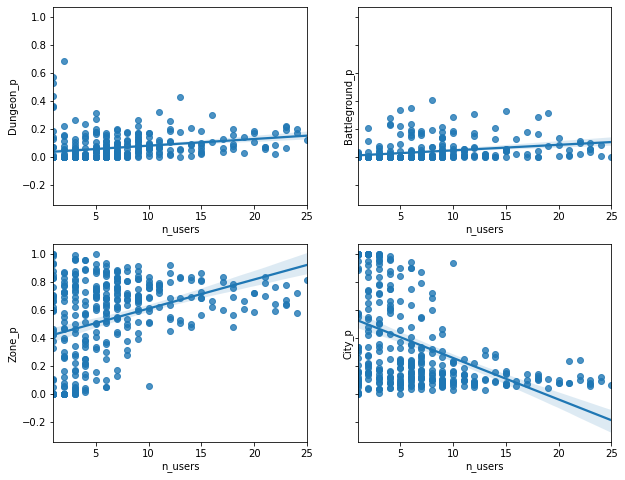

In [162]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(10, 8))
sns.regplot(x='n_users', y='Dungeon_p', data=guild_zone_re2, ax=axes[0, 0])
sns.regplot(x='n_users', y='Battleground_p', data=guild_zone_re2, ax=axes[0, 1])
sns.regplot(x='n_users', y='Zone_p', data=guild_zone_re2, ax=axes[1, 0])
sns.regplot(x='n_users', y='City_p', data=guild_zone_re2, ax=axes[1, 1])

* 길드의 사이즈가 커질수록 던전, 배틀그라운드, zone에서 활동량이 증가
* 반대로 길드 사이즈가 클수록 도시 활동은 감소
* 던전과 배틀그라운드에서 활동을 증가시키려면 길드 규모가 커지게 할 필요가 있음.